This test notebook explores the use of Conguate gradients to perform the solve

In [17]:
import numpy as np
import tensorflow as tf
import tenfem
import matplotlib.pyplot as plt
from tenfem.layers import (AssembleStiffnessMatrix,
                           AssembleLoadVector)

from tensorflow.linalg.experimental import conjugate_gradient

tf_dtype = tf.float32

In [18]:
# create our mesh
mesh = tenfem.mesh.examples.square(2, 2, dtype=tf_dtype)
mesh = tenfem.mesh.triangle.convert_linear_to_quadratic(mesh)
element = tenfem.reference_elements.TriangleElement(degree=2, dtype=tf_dtype)

In [19]:
diffusion_coefficient = lambda x: tf.ones_like(x[..., 0])

mesh_tensor_repr = mesh.get_tensor_repr()
stiffness_matrix = AssembleStiffnessMatrix(diffusion_coefficient,
                                           reference_element=element)(mesh_tensor_repr)

load_vector = AssembleLoadVector(lambda x: tf.ones_like(x)[..., 0],
                                 reference_element=element)(mesh_tensor_repr)

In [22]:
A = stiffness_matrix[0]
b = load_vector[0]

In [ ]:
mesh.get_tensor_repr()

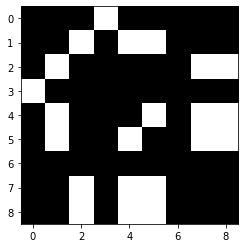

In [4]:
A = stiffness_matrix[0].numpy()
mask = (np.abs(A) < 1e-8).astype(np.intp)

plt.imshow(mask, cmap=plt.cm.gray)

In [5]:
1 - np.sum(mask) / A.size

0.7283950617283951

In [6]:
b = tf.random.normal(shape=[mesh.n_nodes, 1])

In [7]:
import time
t0 = time.time()
res = tf.matmul(A, b)
t1 = time.time()
print(t1 - t0)

0.00038504600524902344


In [8]:
import time
t0 = time.time()
res = tf.linalg.matmul(A, b, a_is_sparse=True)
t1 = time.time()
print(t1 - t0)

Instructions for updating:
Use `tf.linalg.matmul` instead
0.0013027191162109375


In [9]:
element_dim = element.element_dim
mesh_quadrature_nodes = element.get_quadrature_nodes(mesh)
# mesh_quadrature_nodes.shape # [n_elements, element_dim, spatial_dim]
spatial_dim = tf.shape(mesh_quadrature_nodes)[-1]
flat_mesh_quadrature_nodes = tf.reshape(mesh_quadrature_nodes, [-1, 2])

diffusion_coeff_vals = tf.reshape(
    diffusion_coefficient(flat_mesh_quadrature_nodes),
    [-1, mesh.n_elements, element_dim])


local_stiffness_mat = tenfem.fem.assemble_local_stiffness_matrix(
    diffusion_coeff_vals, mesh, element)

In [10]:
local_stiffness_mat.shape # [1, n_elements, 6, 6]

TensorShape([1, 2, 6, 6])

In [11]:
a_local = local_stiffness_mat.shape[0]

In [12]:
inds = tenfem.fem.indexing_utils.get_batched_element_indices(
    mesh.elements[tf.newaxis, ...])

In [13]:
mesh.elements.shape

TensorShape([2, 6])

In [14]:
inds

<tf.Tensor: shape=(72, 3), dtype=int32, numpy=
array([[0, 3, 3],
       [0, 3, 2],
       [0, 3, 0],
       [0, 3, 5],
       [0, 3, 6],
       [0, 3, 4],
       [0, 2, 3],
       [0, 2, 2],
       [0, 2, 0],
       [0, 2, 5],
       [0, 2, 6],
       [0, 2, 4],
       [0, 0, 3],
       [0, 0, 2],
       [0, 0, 0],
       [0, 0, 5],
       [0, 0, 6],
       [0, 0, 4],
       [0, 5, 3],
       [0, 5, 2],
       [0, 5, 0],
       [0, 5, 5],
       [0, 5, 6],
       [0, 5, 4],
       [0, 6, 3],
       [0, 6, 2],
       [0, 6, 0],
       [0, 6, 5],
       [0, 6, 6],
       [0, 6, 4],
       [0, 4, 3],
       [0, 4, 2],
       [0, 4, 0],
       [0, 4, 5],
       [0, 4, 6],
       [0, 4, 4],
       [0, 1, 1],
       [0, 1, 3],
       [0, 1, 0],
       [0, 1, 6],
       [0, 1, 8],
       [0, 1, 7],
       [0, 3, 1],
       [0, 3, 3],
       [0, 3, 0],
       [0, 3, 6],
       [0, 3, 8],
       [0, 3, 7],
       [0, 0, 1],
       [0, 0, 3],
       [0, 0, 0],
       [0, 0, 6],
       [0, 0, 8],